In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)
    cl1 =  tf.cast(tf.greater(input_mask,1.),tf.float32)*2
    cl2 =  tf.cast(tf.less(input_mask,1.),tf.float32)
    input_mask = tf.zeros(tf.shape(input_mask))+cl1+cl2

    return input_image, input_mask#, input_mask2

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZ9RU1B/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZ9RU1B/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomBrightness, RandomRotation,RandomCrop,RandomTranslation,RandomContrast
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # Add data augmentation

    # # these layers will actually scale the image to become bigger
    # self.random_crop_layer1 = RandomCrop(131, 131, seed=seed)
    # self.random_crop_layer1_2 = RandomCrop(131, 131, seed=seed)
    # # these layers will crop the image again to the initial dimension
    # self.random_crop_layer2_1 = RandomCrop(128, 128, seed=seed)
    # self.random_crop_layer2_2 = RandomCrop(128, 128, seed=seed)

    self.random_flip_layer1 = RandomFlip(mode="horizontal", seed=seed)
    self.random_flip_layer2 = RandomFlip(mode="horizontal", seed=seed)
    self.random_brightness_layer1 = RandomBrightness(factor=0.15, value_range=(50, 100), seed=seed)
    self.random_contrast_layer = RandomContrast(factor=0.1, seed=seed)
    # self.random_translation_layer1 = RandomTranslation(0.1, 0.1, seed=seed)
    self.random_translation_layer1 = RandomTranslation(0.1, 0, seed=seed)
    # self.random_translation_layer2 = RandomTranslation(0.1, 0.1,seed=seed)
    self.random_translation_layer2 = RandomTranslation(0.1, 0,seed=seed)
    # self.random_rotation_layer1 = RandomRotation(0.05, seed=seed)
    # self.random_rotation_layer2 = RandomRotation(0.05, seed=seed)


  def call(self, inputs, labels):
    # Add data augmentation

    x_aug = self.random_flip_layer1(inputs)
    x_aug = self.random_contrast_layer(x_aug)
    # x_aug = self.random_translation_layer1(x_aug)

    labels_aug = self.random_flip_layer2(labels)
    # labels_aug = self.random_translation_layer2(labels_aug)

    return x_aug, labels_aug

Note: I observed that there are some mislabeled images. For example, in the image below, the upper margin was also labelled before the augmentation, therefore a line appears on the image.

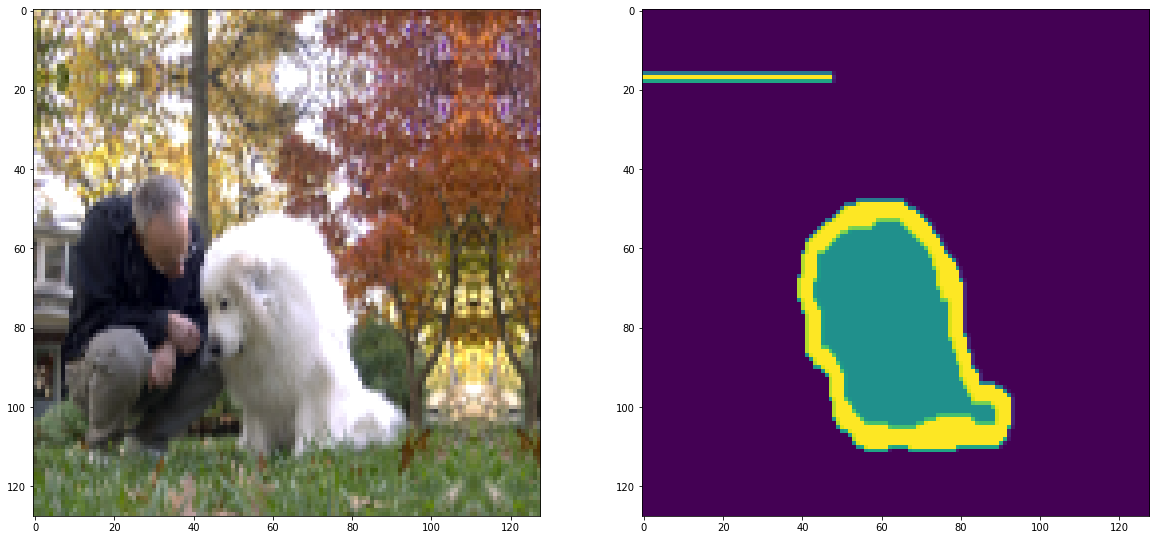

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
for x,y in train_batches.take(2):
    print("X",x.shape, "Y",y.shape)

X (64, 128, 128, 3) Y (64, 128, 128, 1)
X (64, 128, 128, 3) Y (64, 128, 128, 1)


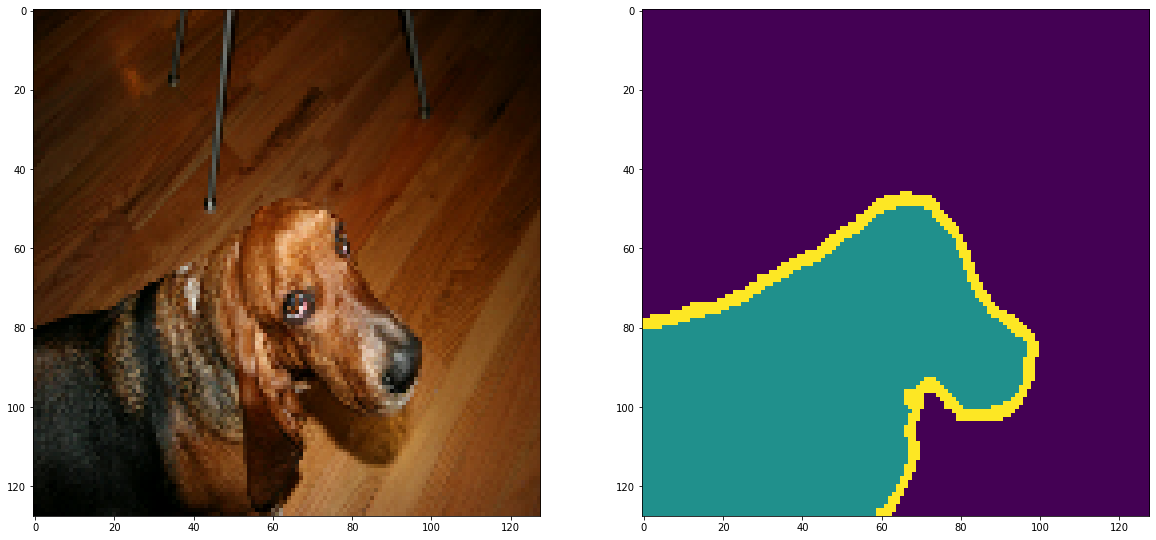

In [ ]:
fig = plt.figure(figsize=(20,10))
gs  = grid.GridSpec(1,2)

i = 7

ax = plt.subplot(gs[0,0])
ax.imshow(x[i])

ax = plt.subplot(gs[0,1])
ax.imshow(y[i][:,:,0])

In [ ]:
# # For MobileNetV2:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False, weights='imagenet')

# # Names of blocks
# layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]

# # Get outputs for each block
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# # Wrap model to generate multiple outputs instead of one
# base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# base_model.summary()

Using the pretrained Vgg16 model: [paper: https://arxiv.org/pdf/1409.1556.pdf ]

In [ ]:
# Using pretrained TF models

# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=[128, 128, 3],
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# the initial VGG16net architecture:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:

class Encoder(tf.keras.Model):
   def __init__(self,num_classes=3):
      super(Encoder, self).__init__()

      # Names of blocks
      self.layer_names = [
        'block1_conv2',
        'block1_pool',
        'block2_conv2',
        'block2_pool',
        'block3_conv3',
        'block3_pool',
        'block4_conv3',
        'block4_pool',
        'block5_conv3',
      ]

      # Get outputs for each block
      self.base_model_outputs = [base_model.get_layer(name).output for name in self.layer_names]

      # Wrap model to generate multiple outputs instead of one
      self.base_model = tf.keras.Model(inputs=base_model.input, outputs=self.base_model_outputs)

   def call(self, inputs):
    return self.base_model(inputs)


In [ ]:
A = Encoder()
A.base_model_outputs

ListWrapper([<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_conv2')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'block1_pool')>, <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_conv2')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'block2_pool')>, <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_conv3')>, <KerasTensor: shape=(None, 16, 16, 256) dtype=float32 (created by layer 'block3_pool')>, <KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block4_conv3')>, <KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block4_pool')>, <KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_conv3')>])

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Concatenate, BatchNormalization, Activation

class Decoder(tf.keras.Model):
    def __init__(self,num_classes=3):
        super(Decoder, self).__init__()

        # U-Net decoder should consist of Conv2DTranspose layers to upsample and Conv2D layers to merge embeddings (see Fig. 1 in U-Net paper linked below)

        # 'block4_conv3'
        self.conv2Dt1 = Conv2DTranspose(64, (2,2), 2, padding="same" )
        self.conv2D1 = Conv2D(64, (3,3), activation="relu", padding="same" )

        # 'block3_conv3'
        self.conv2Dt2 = Conv2DTranspose(128, (2,2), 2, padding="same" )
        self.conv2D2= Conv2D(128, (3,3), activation="relu", padding="same" )

        # 'block2_conv2'
        self.conv2Dt3   = Conv2DTranspose(256, (2,2), 2, padding="same" )
        self.conv2D3 = Conv2D(256, (3,3), activation="relu", padding="same" )

        # 'block1_conv2'
        self.conv2Dt4 = Conv2DTranspose(512, (2,2), 2, padding="same" )
        self.conv2D4 = Conv2D(512, (3,3), activation="relu", padding="same" )

        # layer for the predictions
        self.out_layer = Conv2D(3, 1, padding="same")


    def call(self, inputs, training = False):

        # using the block5_conv3 layer as the "bridge" to get input for the decoder (inputs[8])
        # 'block5_conv3'
        x = self.conv2Dt4(inputs[8])
        x = Concatenate()([x, inputs[6]])
        x = self.conv2D4(x)

        x = self.conv2Dt3(x)
        x = Concatenate()([x, inputs[4]])
        x = self.conv2D3(x)


        x = self.conv2Dt2(x)
        x = Concatenate()([x, inputs[2]])
        x = self.conv2D2(x)

        x = self.conv2Dt1(x)
        x = Concatenate()([x, inputs[0]])
        x = self.conv2D1(x)

        out = self.out_layer(x)
        return out

In [ ]:
class Unet(tf.keras.Model):

    def __init__(self, num_classes=3):
        super(Unet, self).__init__()

        # Create the feature extraction model
        self.encoder = Encoder()

        # In case you load a pretrained encoder and dont want to train it to speed up computation
        # self.encoder.trainable = False
        self.encoder.trainable = True

        self.decoder = Decoder(num_classes=num_classes)

    def call(self, inputs, training = False):

        embedding = self.encoder(inputs)

        # Here the embeddings is a list of outputs for each U-Net level
        pred = self.decoder(embedding)

        return pred

### Intersection Over Union implementation


$iou = \frac{|A \cap B|}{|A \cup B|}$

In [ ]:
import numpy as np
from keras import backend as K

def iou(target, prediction):
  """
  Multiclass IoU that can be passed as a metric to tensorflow (if possible this should return an iou score per class for evaluation)
    intersection over union
  """
  # get the prediction:
  pred = K.argmax(prediction, axis=3)
  # reduce the last dimension of 1 from targets:
  target = tf.squeeze(target)

  score = []

  for label in [0, 1, 2]:
    # get 2 boolean arrays of data where it has the required label
    target_labels = K.cast(K.equal(target,label), "float32")
    pred_labels = K.cast(K.equal(pred,label),  "float32")

    # use a logical and to get only entries where both targets and preds are true:
    count_intersect = K.sum(target_labels * pred_labels)
    count_union = K.sum(target_labels) + K.sum(pred_labels) - count_intersect

    score_per_class =  tf.math.divide_no_nan(count_intersect, count_union)

    score.append(score_per_class)


  return score

In [ ]:
OUTPUT_CLASSES = 3

model = Unet(num_classes=OUTPUT_CLASSES)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',iou])

In [ ]:
model.fit(x=train_batches,steps_per_epoch=STEPS_PER_EPOCH,epochs=30, validation_data=test_batches, validation_steps=10)

Epoch 1/30
57/57 [==============================] - 68s 762ms/step - loss: 0.9308 - accuracy: 0.6171 - iou: 0.3085 - val_loss: 0.6334 - val_accuracy: 0.7451 - val_iou: 0.4692
Epoch 2/30
57/57 [==============================] - 50s 748ms/step - loss: 0.5764 - accuracy: 0.7689 - iou: 0.5061 - val_loss: 0.5260 - val_accuracy: 0.7906 - val_iou: 0.5389
Epoch 3/30
57/57 [==============================] - 43s 749ms/step - loss: 0.4909 - accuracy: 0.8052 - iou: 0.5630 - val_loss: 0.4519 - val_accuracy: 0.8207 - val_iou: 0.5973
Epoch 4/30
57/57 [==============================] - 43s 748ms/step - loss: 0.4474 - accuracy: 0.8247 - iou: 0.5974 - val_loss: 0.4052 - val_accuracy: 0.8418 - val_iou: 0.6319
Epoch 5/30
57/57 [==============================] - 43s 751ms/step - loss: 0.3921 - accuracy: 0.8483 - iou: 0.6394 - val_loss: 0.3649 - val_accuracy: 0.8598 - val_iou: 0.6620
Epoch 6/30
57/57 [==============================] - 43s 752ms/step - loss: 0.3535 - accuracy: 0.8641 - iou: 0.6659 - val_loss

In [ ]:
# idea:
# from plot_keras_history import show_history
# https://pypi.org/project/plot-keras-history/

In [ ]:
ious = []
for x,y in test_batches.take(50):
    pred = model(x)
    iou_ = np.array(iou(y,pred))
    # print("iou:", iou_)
    ious.append(iou_)

In [ ]:
np.mean(ious,0)

array([0.9106397 , 0.83558345, 0.53527564], dtype=float32)

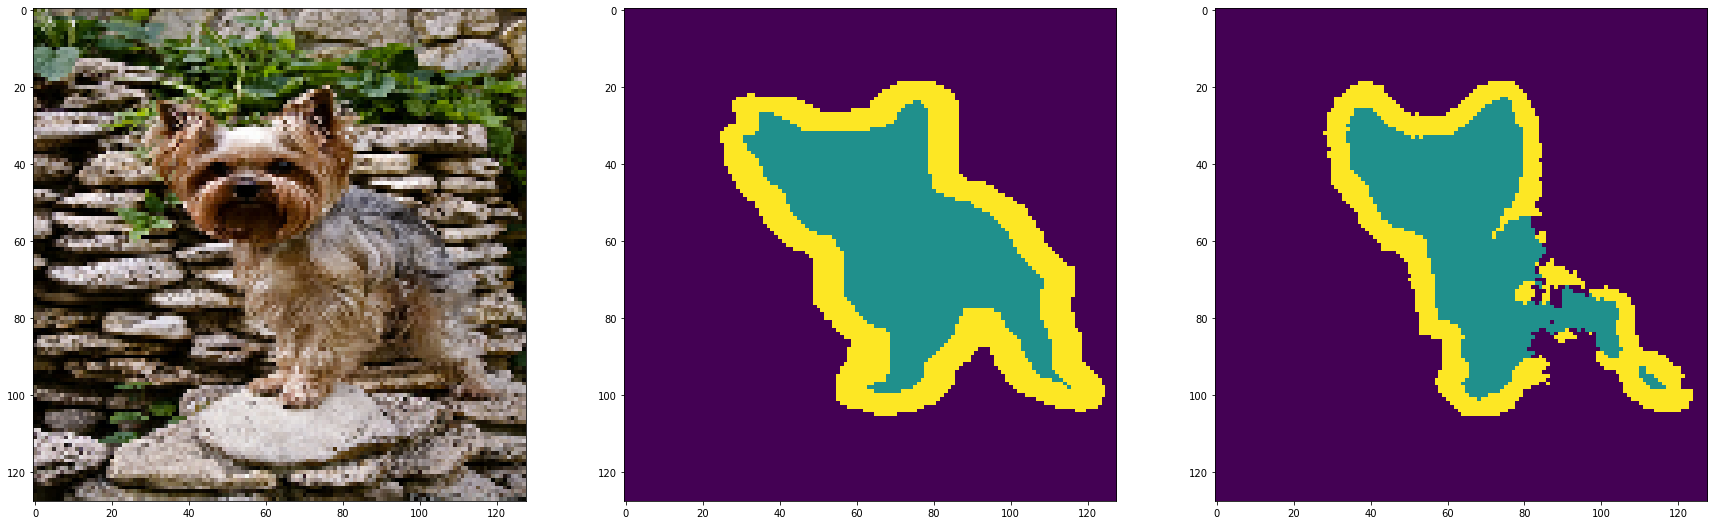

In [ ]:
fig = plt.figure(figsize=(30,10))
gs  = grid.GridSpec(1,3)

i = 1

ax = plt.subplot(gs[0,0])
ax.imshow(x[i])

ax = plt.subplot(gs[0,1])
ax.imshow(y[i][:,:,0])

ax = plt.subplot(gs[0,2])
ax.imshow(np.argmax(pred,-1)[i])

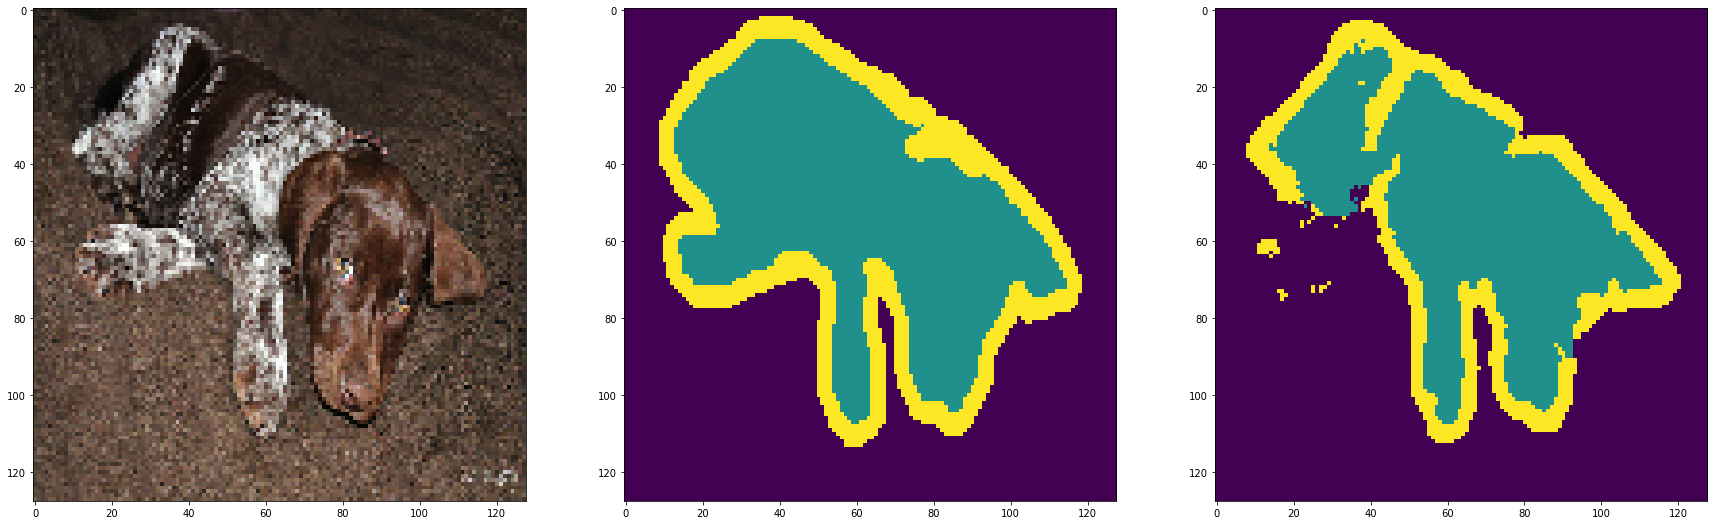

In [ ]:
fig = plt.figure(figsize=(30,10))
gs  = grid.GridSpec(1,3)

i = 2

ax = plt.subplot(gs[0,0])
ax.imshow(x[i])

ax = plt.subplot(gs[0,1])
ax.imshow(y[i][:,:,0])

ax = plt.subplot(gs[0,2])
ax.imshow(np.argmax(pred,-1)[i])

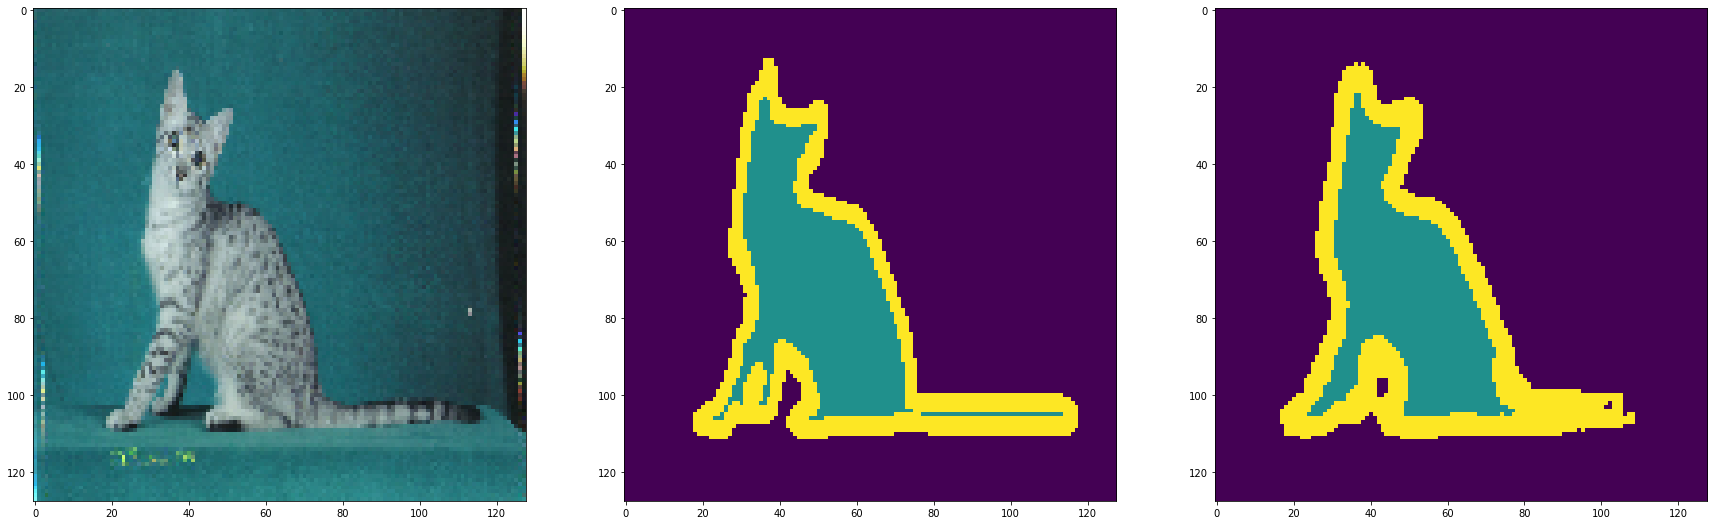

In [ ]:
fig = plt.figure(figsize=(30,10))
gs  = grid.GridSpec(1,3)

i = 10

ax = plt.subplot(gs[0,0])
ax.imshow(x[i])

ax = plt.subplot(gs[0,1])
ax.imshow(y[i][:,:,0])

ax = plt.subplot(gs[0,2])
ax.imshow(np.argmax(pred,-1)[i])

# Exercise

1) Take a look at the [U-Net architecture](https://link.springer.com/content/pdf/10.1007/978-3-319-24574-4_28.pdf) by Ronneberge et al. (2015). The goal is to implement a U-Net for semantic image segmentation meaning an encoder-decoder sequence-to-sequence model with skip connections between each layer of the encoder and decoder. You can freely design the encoder and decoder, but it is also allowed to load a pretrained encoder (e.g. MobileNetV2).

2) Furthermore, implement the Augment class (by using any data augmentation of your choice) and the function **iou** which computes a per-class Intersection-over-Union score. The metric needs to be passed to your model training (via fit or custom).

3) Goal is achieve a test accuracy of >85% with a IoU of > [0.85 , 0.70 , 0.40] for the three classes background, dog, outline

Bonus  (3 points) Class IoU's >[0.91 , 0.83 , 0.53], val_acc >92%
The per class IoUs should be computed over 100 test batches as demonstrated above.